## Collect all .raw file names in the input_dir directory

In [34]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import multiprocessing
import copy

"""
name format is "IMG####_MMDD.hhmmss.xxx.raw"
where
- `IMG is literally "IMG"
- `####` is 0001 to 9999
- `MMDD` is month and day with leading zeros, like 0602
- `hhmmss` is hour, minute and second with leading zeros, like 172541
- `xxx` is microsecond with leading zeros, like 622
- `raw` is literally "raw"
"""
def read_raw_file(tuple):
	sequence, raw_file = tuple
	array_1d = np.fromfile(raw_file, dtype=np.dtype("<u2")) # little‑endian unsigned short
	array_2d = array_1d.reshape(2560, 2048)	# height, width
	TRIM_TOP = 12
	TRIM_LEFT = 12
	TRIM_RIGHT = 448
	TRIM_BOTTOM = 12
	array_crop = array_2d[TRIM_TOP:2560-TRIM_BOTTOM, TRIM_LEFT:2048-TRIM_RIGHT]  # Crop the array
	return sequence, array_crop

def get_dic_from_dir(input_dir):
	dic = {}
	raw_files = list(input_dir.glob("*.raw"))

	if not raw_files:
		print("No raw files found.")
		exit(1)

	is_first = True
	for raw_file in raw_files:
		#          11111111112
		#012345678901234567890
		#IMG####_mmdd.HHMMSS.xxx.raw
		sequence = int(raw_file.stem[4:7])
		date_string = raw_file.stem[8:19]
		#print(f"Found raw file: {raw_file.name}, {sequence}, {date_string}")
		date_image = datetime.datetime.strptime(date_string, "%m%d.%H%M%S")

		if is_first:
			is_first = False
			date_first = date_image

		stamp = (date_image - date_first).total_seconds()
		dic[sequence] = {}
		dic[sequence]["raw_file"] = raw_file
		dic[sequence]["stamp"] = stamp
	
	pool = multiprocessing.Pool()
	list_tuple = [(sequence, dic[sequence]["raw_file"]) for sequence in dic.keys()]
	pool_results = pool.map(read_raw_file, list_tuple)
	pool.close()
	pool.join()

	for sequence, array_crop in pool_results:
		dic[sequence]["array"] = array_crop

	return dic



## Plot mean and stddev

In [35]:
def plot_mean(dic, ax):
	list_x = []
	list_y = []

	for sequence in sorted(dic.keys()):
		stamp = dic[sequence]["stamp"]
		array = dic[sequence]["array"]
		mean = array.mean()
		list_x.append(stamp)
		list_y.append(mean)

	ax.plot(list_x, list_y)
	ax.set_title("Mean")

def plot_std(dic, ax):
	list_x = []
	list_y = []

	for sequence in sorted(dic.keys()):
		stamp = dic[sequence]["stamp"]
		array = dic[sequence]["array"]
		std = array.std()
		list_x.append(stamp)
		list_y.append(std)

	ax.plot(list_x, list_y)



## Split into [low and high]

In [36]:

def split_odd_and_even(dic):
	dic_odd = {}
	dic_even = {}
	for sequence in sorted(dic.keys()):
		if sequence % 2 == 0:
			dic_even[sequence] = dic[sequence]
		else:
			dic_odd[sequence] = dic[sequence]
	return dic_odd, dic_even

input_dir_off = pathlib.Path("data/250605/off").resolve()
input_dir_on = pathlib.Path("data/250605/on").resolve()
dic_off = get_dic_from_dir(input_dir_off)
dic_on = get_dic_from_dir(input_dir_on)
(dic_off_low, dic_off_high) = split_odd_and_even(dic_off)
(dic_on_low, dic_on_high) = split_odd_and_even(dic_on)



### Changes in the mean and standard deviation of radiation intensity over time, for OFF images

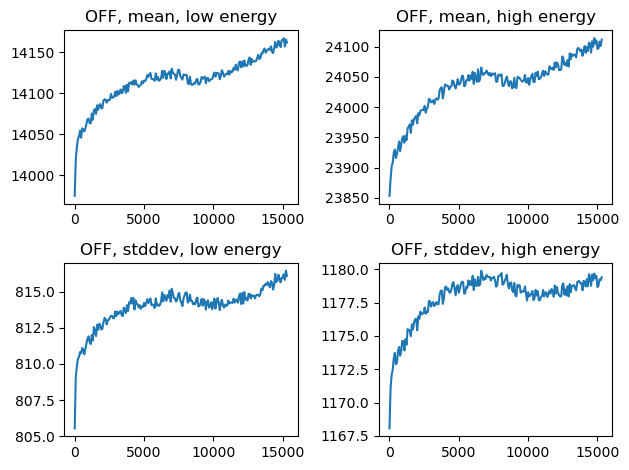

In [37]:
fig, axs = plt.subplots(2, 2)
plot_mean(dic_off_low, ax=axs[0, 0])
plot_std(dic_off_low, ax=axs[1, 0])
plot_mean(dic_off_high, ax=axs[0, 1])
plot_std(dic_off_high, ax=axs[1, 1])
axs[0, 0].set_title("OFF, mean, low energy")
axs[1, 0].set_title("OFF, stddev, low energy")
axs[0, 1].set_title("OFF, mean, high energy")
axs[1, 1].set_title("OFF, stddev, high energy")
plt.tight_layout()
plt.show()

### Changes in the mean and standard deviation of radiation intensity over time, for ON images

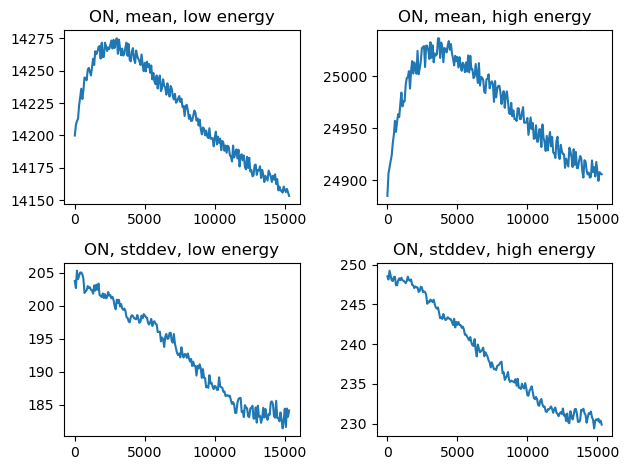

In [38]:
fig, axs = plt.subplots(2, 2)
plot_mean(dic_on_low, ax=axs[0, 0])
plot_std(dic_on_low, ax=axs[1, 0])
plot_mean(dic_on_high, ax=axs[0, 1])
plot_std(dic_on_high, ax=axs[1, 1])
axs[0, 0].set_title("ON, mean, low energy")
axs[1, 0].set_title("ON, stddev, low energy")
axs[0, 1].set_title("ON, mean, high energy")
axs[1, 1].set_title("ON, stddev, high energy")
plt.tight_layout()
plt.show()

In [39]:
def show_distribution(array, title):
	plt.figure(figsize=(8, 4))
	plt.hist(array.ravel(), bins=1000, color='gray')
	plt.title(title)
	plt.xlabel('Pixel Intensity')
	plt.ylabel('Frequency')
	plt.grid(False)
	plt.show()

def show_distribution_log_scale(array, title):
	fig, ax = plt.subplots(figsize=(8, 4))
	ax.hist(array.ravel(), bins=1000, color='gray')
	ax.set_title(title)
	ax.set_xlabel('Pixel Intensity')
	ax.set_ylabel('Frequency')
	ax.set_yscale('log')
	ax.grid(False)
	plt.show()

def img_show(array, title):
	# Calculate mean along each axis
	mean_x_axis = np.mean(array, axis=0) # Mean along columns
	mean_y_axis = np.mean(array, axis=1) # Mean along rows

	# Create subplots
	fig, ax = plt.subplots(1, 3, figsize=(12, 4)) # One row, three columns

	# Plot the image
	im = ax[0].imshow(array, cmap='rainbow') # Display image in 'rainbow' colormap
	ax[0].set_title('Original Image')
	ax[0].set_xlabel('X-axis (Columns)')
	ax[0].set_ylabel('Y-axis (Rows)')
	fig.colorbar(im, ax=ax[0], orientation='vertical', label='Intensity')


	# Plot the mean along the X-axis
	ax[1].plot(mean_x_axis)
	ax[1].set_title('Mean along X-axis')
	ax[1].set_xlabel('X-axis (Columns)')
	ax[1].set_ylabel('Mean Intensity')

	# Plot the mean along the Y-axis
	ax[2].plot(mean_y_axis, range(len(mean_y_axis))) # Plot against y-axis indices
	ax[2].set_title('Mean along Y-axis')
	ax[2].set_xlabel('Mean Intensity')
	ax[2].set_ylabel('Y-axis (Rows)')
	ax[2].invert_yaxis() # Invert y-axis to match image orientation

	plt.suptitle(title, fontsize=16)
	plt.tight_layout()
	plt.show()



## Comparison of off/on images

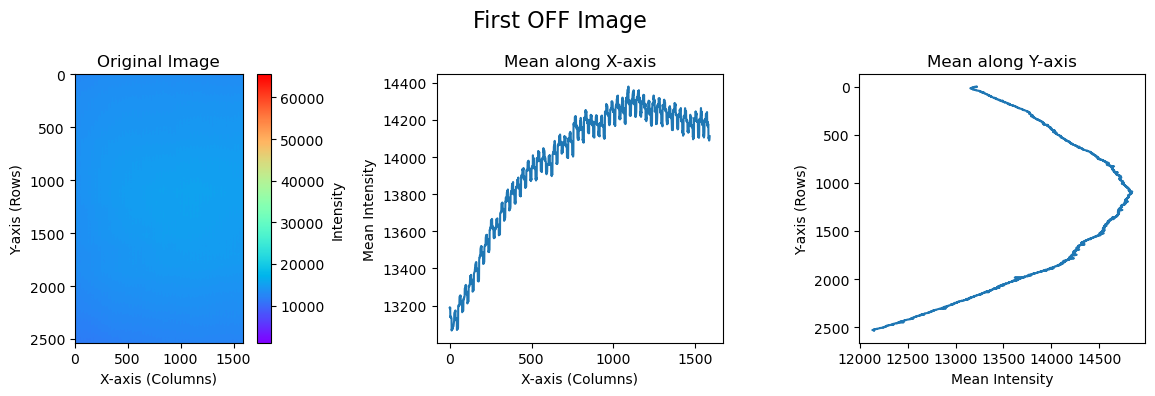

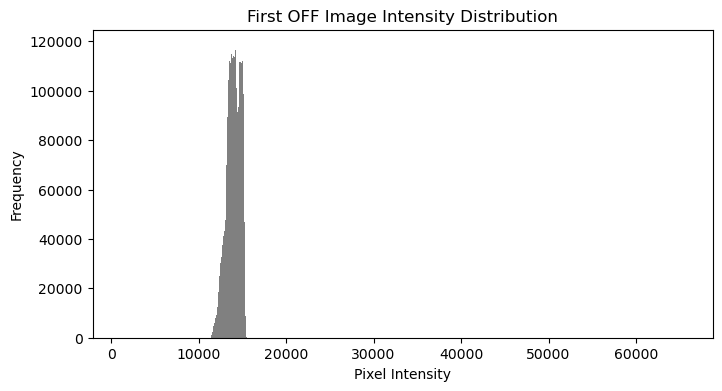

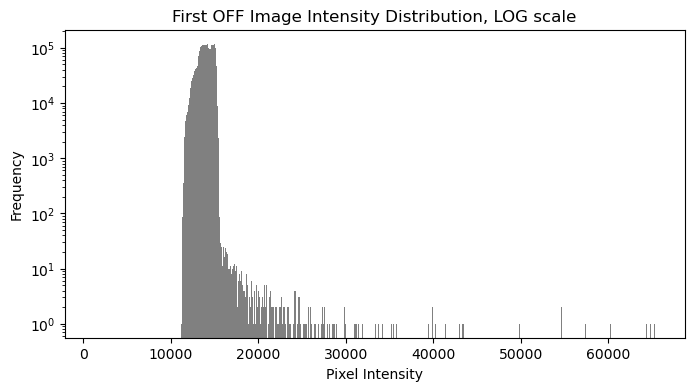

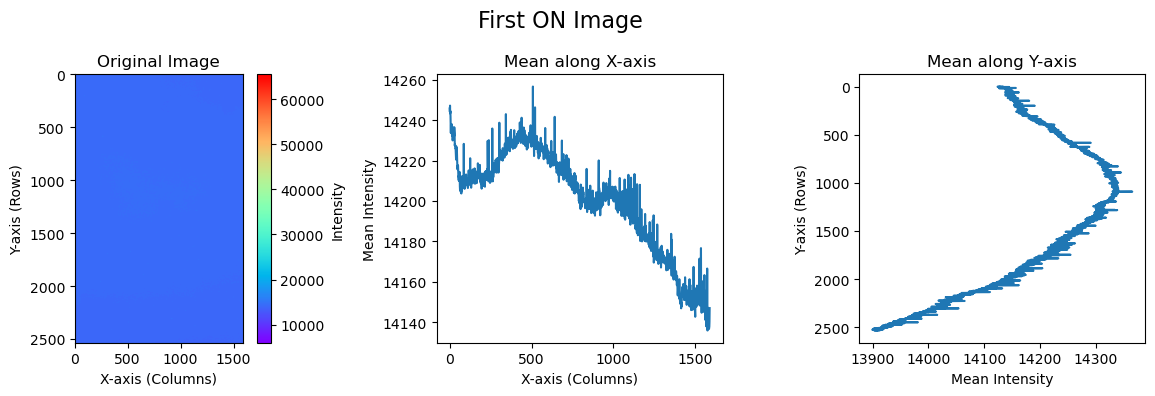

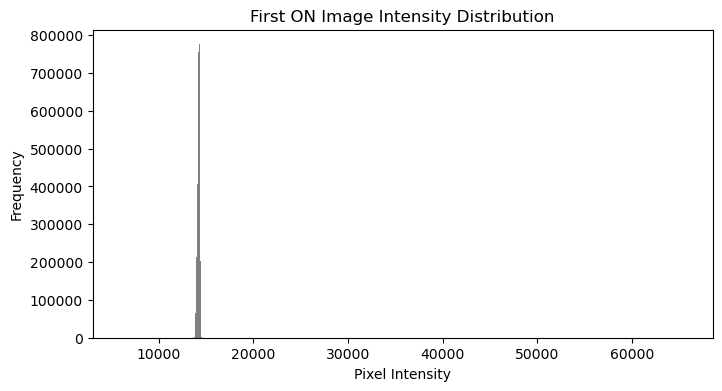

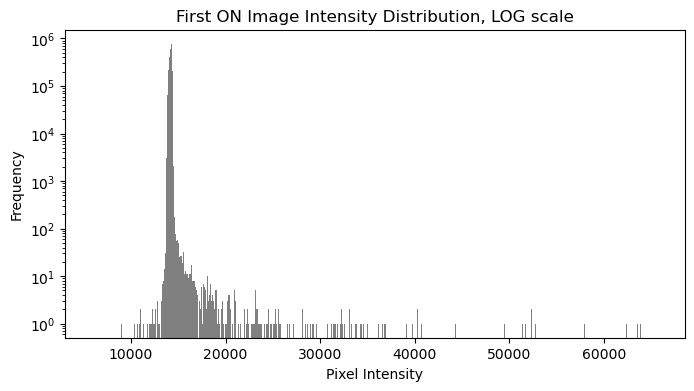

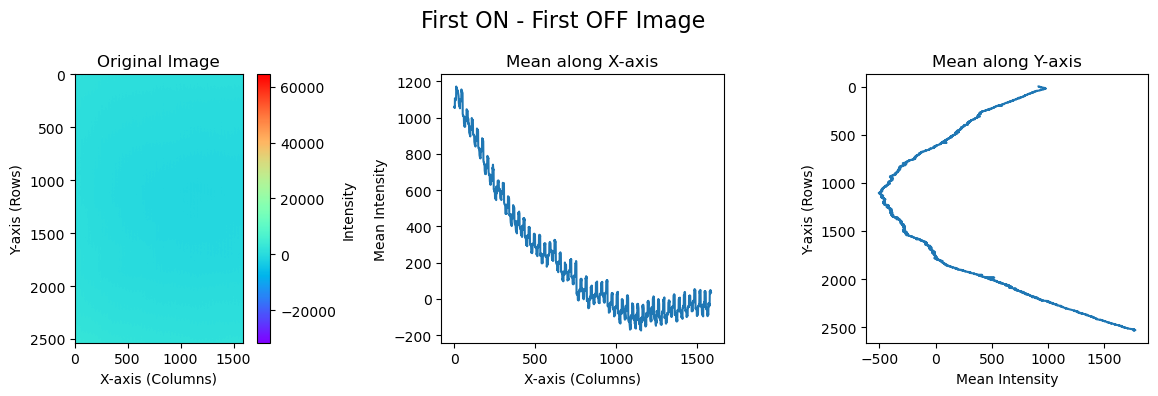

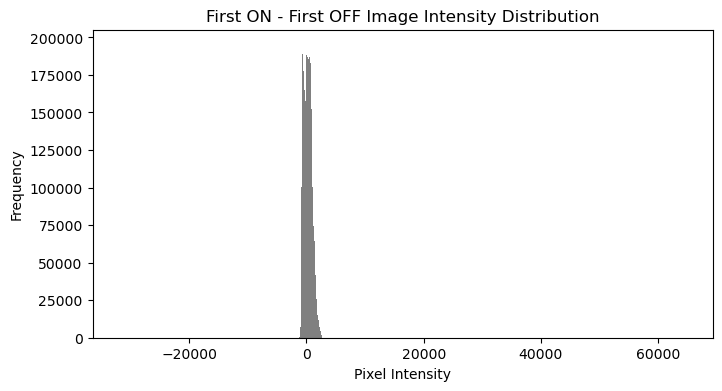

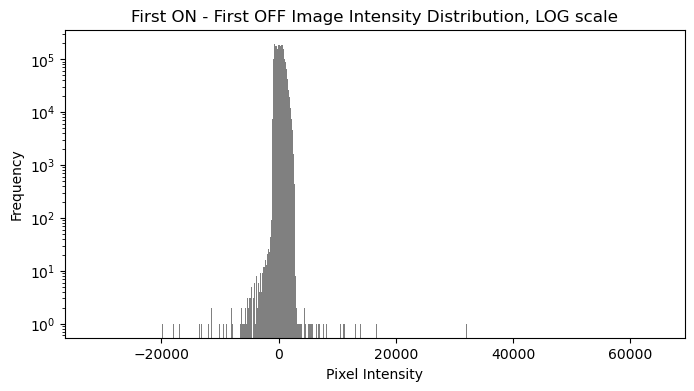

In [40]:
# pick one sample and visualize its features
array_off = dic_off_low[1]["array"]
array_on = dic_on_low[1]["array"]
array_diff = array_on.astype(float) - array_off.astype(float)

img_show(array_off, "First OFF Image")
show_distribution(array_off, "First OFF Image Intensity Distribution")
show_distribution_log_scale(array_off, "First OFF Image Intensity Distribution, LOG scale")
img_show(array_on, "First ON Image")
show_distribution(array_on, "First ON Image Intensity Distribution")
show_distribution_log_scale(array_on, "First ON Image Intensity Distribution, LOG scale")
img_show(array_diff, "First ON - First OFF Image")
show_distribution(array_diff, "First ON - First OFF Image Intensity Distribution")
show_distribution_log_scale(array_diff, "First ON - First OFF Image Intensity Distribution, LOG scale")

## Difference bewteen the first and the last images

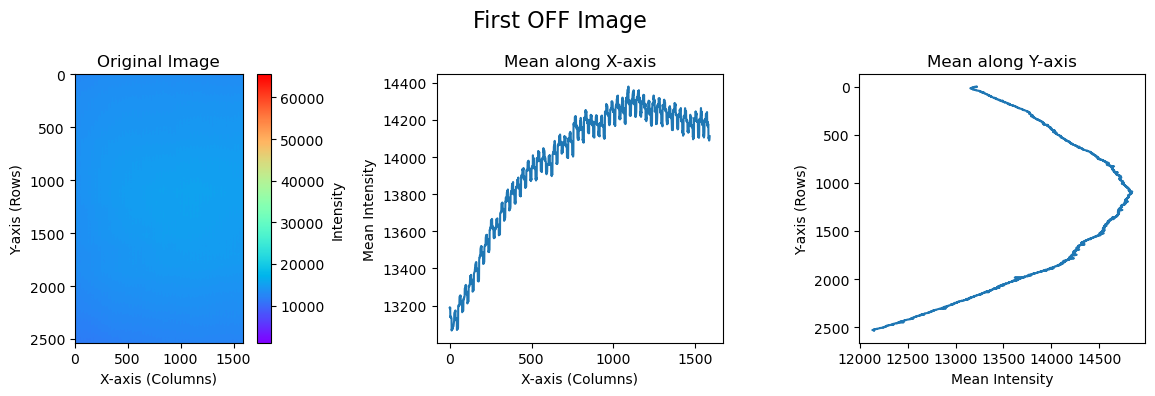

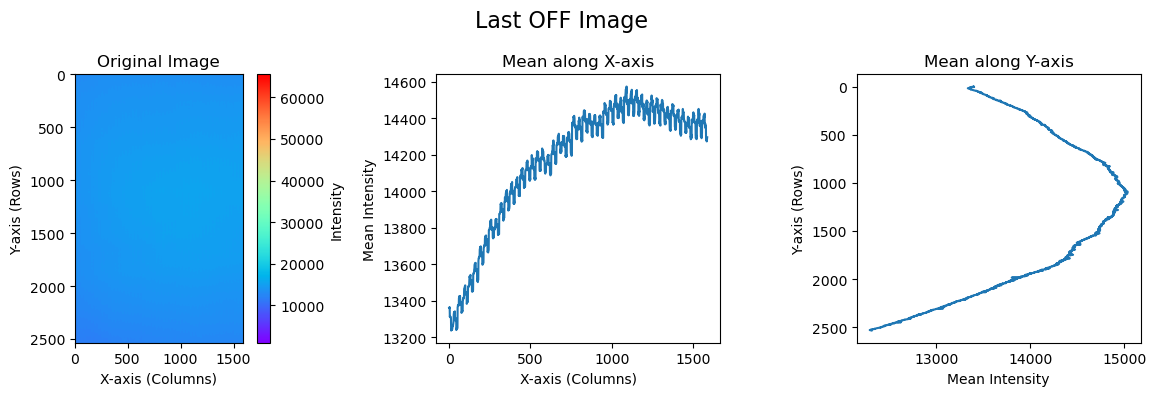

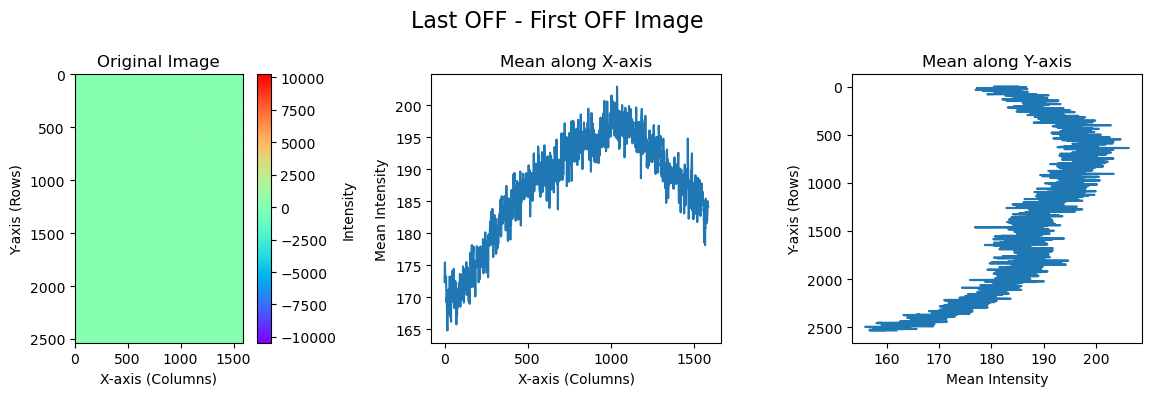

In [41]:
# pick one sample and visualize its features
array_first = dic_off_low[1]["array"]
array_last = dic_off_low[399]["array"]
array_diff = array_last.astype(float) - array_first.astype(float)

img_show(array_first, "First OFF Image")
img_show(array_last, "Last OFF Image")
img_show(array_diff, "Last OFF - First OFF Image")




## Correction methods

In [42]:
def get_mean_4_corners(array):
    # Get the mean intensity of the 4 corners
    CORNER_SIZE = 100
    array_corner = np.concatenate([
        array[0:CORNER_SIZE, 0:CORNER_SIZE],
        array[0:CORNER_SIZE, -CORNER_SIZE-1:-1],
        array[-CORNER_SIZE-1:-1, 0:CORNER_SIZE],
        array[-CORNER_SIZE-1:-1, -CORNER_SIZE-1:-1]
    ])
    mean_4_corners = np.mean(array_corner)
    return mean_4_corners

def get_correction_matrix(array):

    VALUE_TARGET = 40000  # XXX: What an arbitrary unreasonable value !
    mean_4_corners = get_mean_4_corners(array)
    array_correction = VALUE_TARGET * mean_4_corners / array.astype(float)
    return array_correction

def get_corrected_matrix(array, array_correction):
    mean_4_corners = get_mean_4_corners(array)
    array_corrected = array.astype(float) * array_correction / mean_4_corners
    return array_corrected.astype(np.uint16)



## Correction using the first image

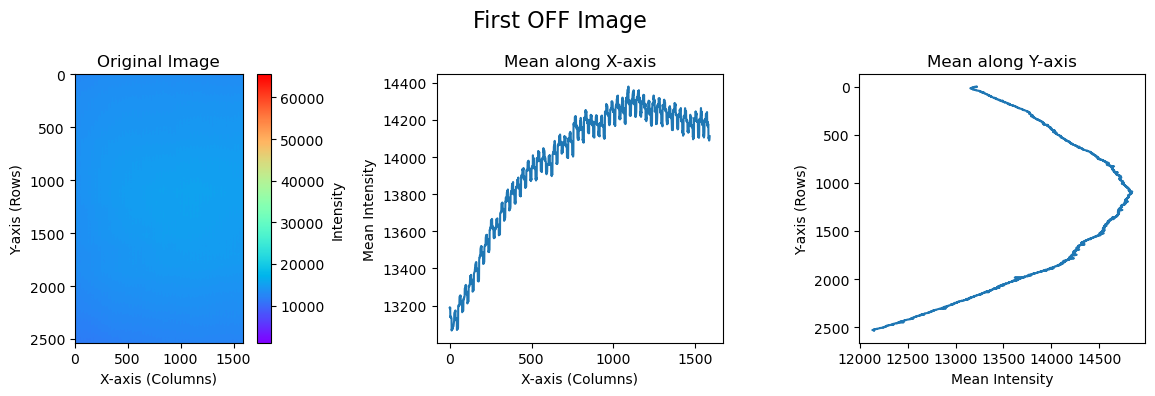

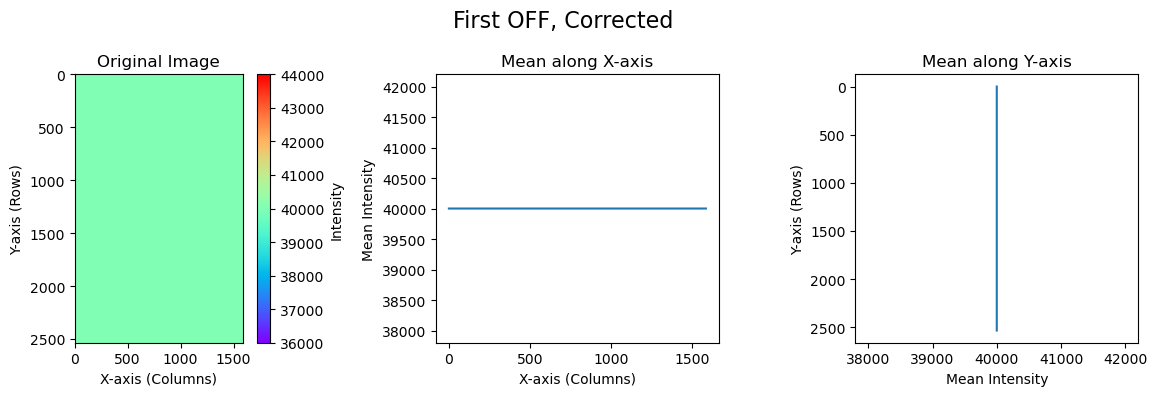

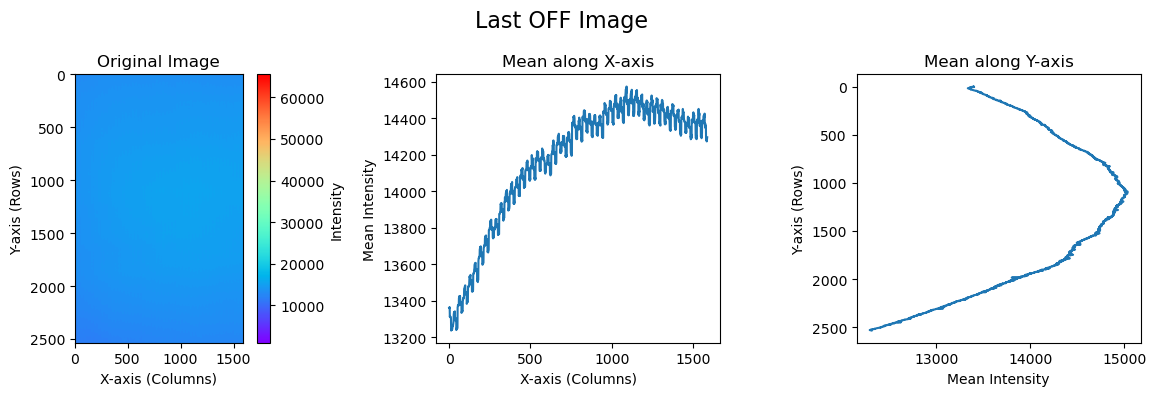

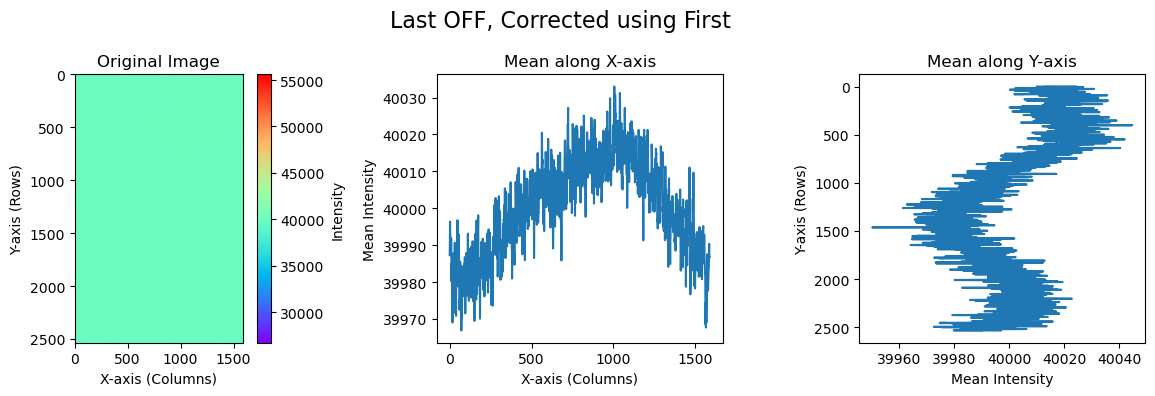

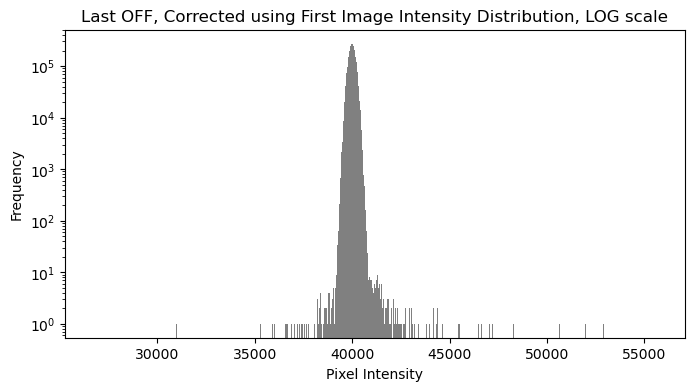

In [43]:
# pick one sample and visualize its features
array_first = dic_off_low[1]["array"]
array_correction = get_correction_matrix(array_first)
np.savetxt(pathlib.Path("data/250605_off/correction1.txt").resolve(), array_correction, fmt="%.3f", delimiter=",")
array_first_corrected = get_corrected_matrix(array_first, array_correction)

array_last = dic_off_low[399]["array"]
array_last_corrected = get_corrected_matrix(array_last, array_correction)

img_show(array_first, "First OFF Image")
img_show(array_first_corrected, "First OFF, Corrected")
img_show(array_last, "Last OFF Image")
img_show(array_last_corrected, "Last OFF, Corrected using First")
show_distribution_log_scale(array_last_corrected, "Last OFF, Corrected using First Image Intensity Distribution, LOG scale")

## Correction using the last image

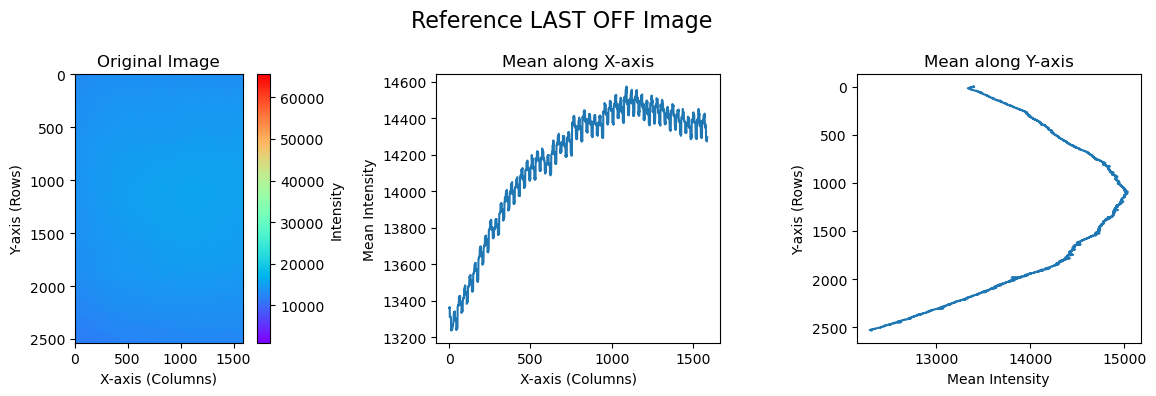

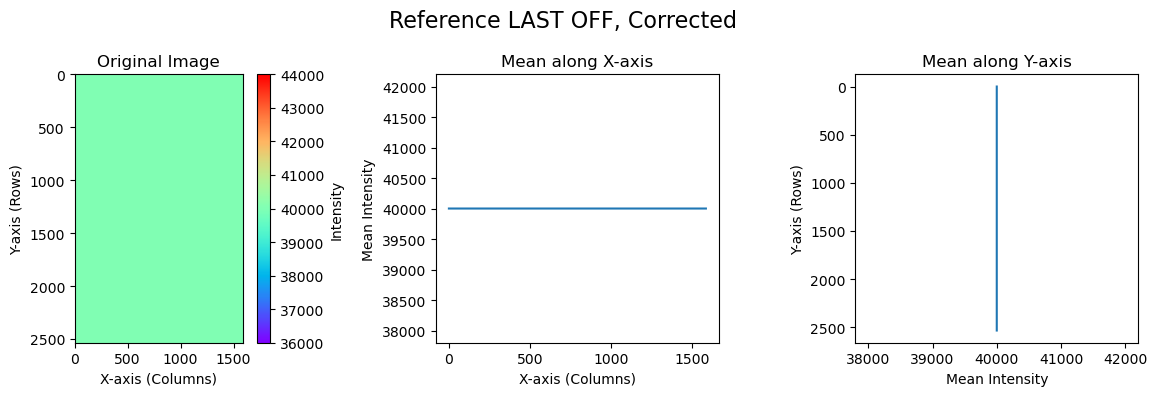

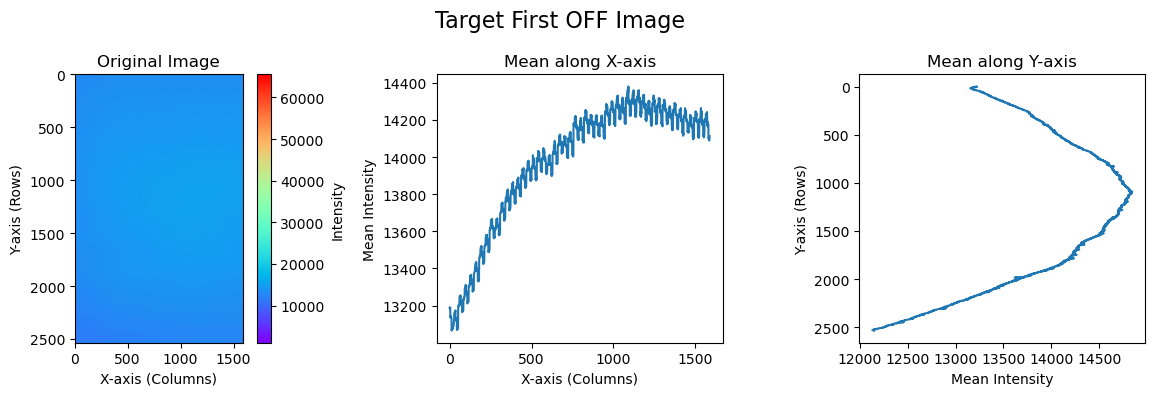

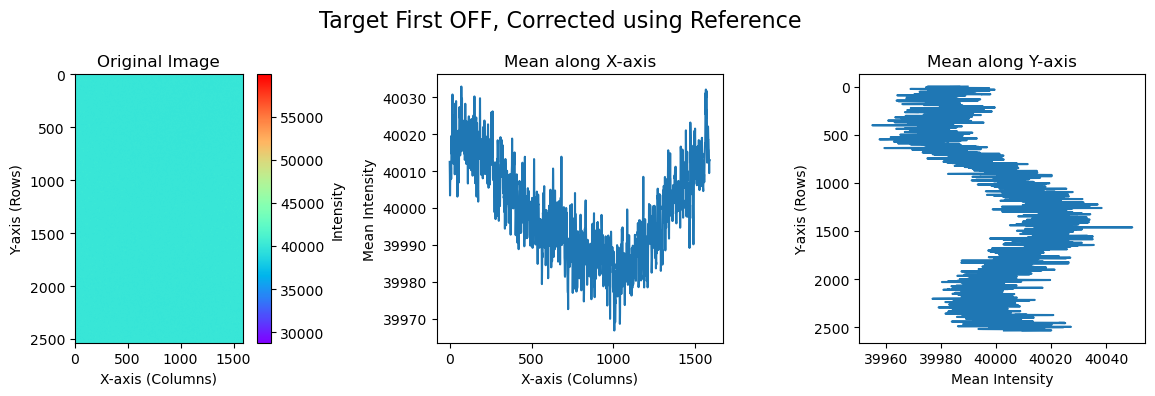

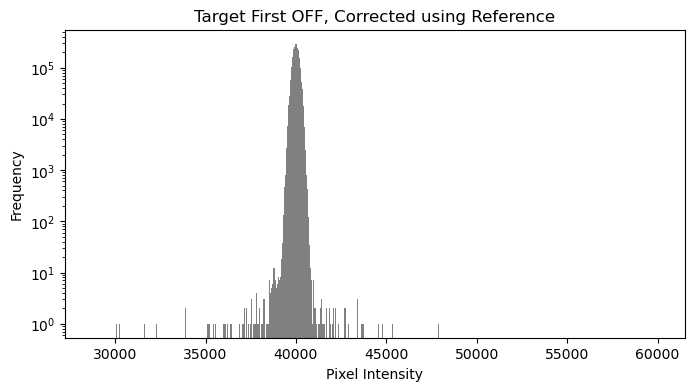

In [44]:

# pick one sample and visualize its features
array_reference = dic_off_low[399]["array"]
array_correction = get_correction_matrix(array_reference)
array_reference_corrected = get_corrected_matrix(array_reference, array_correction)
np.savetxt(pathlib.Path("data/250605_off/correction399.txt").resolve(), array_correction, fmt="%.3f", delimiter=",")

array_target = dic_off_low[1]["array"]
array_target_corrected = get_corrected_matrix(array_target, array_correction)

img_show(array_reference, "Reference LAST OFF Image")
img_show(array_reference_corrected, "Reference LAST OFF, Corrected")
img_show(array_target, "Target First OFF Image")
img_show(array_target_corrected, "Target First OFF, Corrected using Reference")
show_distribution_log_scale(array_target_corrected, "Target First OFF, Corrected using Reference")

## Apply to all images and save to PNG files

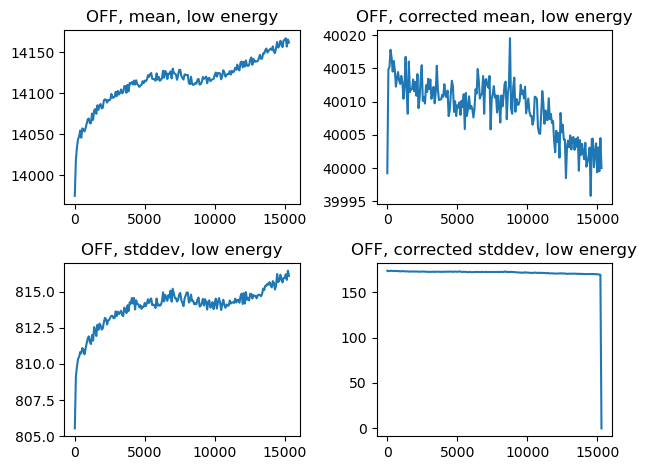

In [45]:
import PIL

def array_to_png(key):
    im = PIL.Image.fromarray(dic_off_low_corrected[key]["array"], mode="I;16")
    im.save(f"data/250605_off/corrected{key:03d}.png")

def run_in_pool(keys):
    pool = multiprocessing.Pool()
    pool.map(array_to_png, keys)
    pool.close()
    pool.join()

fig, axs = plt.subplots(2, 2)
plot_mean(dic_off_low, ax=axs[0, 0])
plot_std(dic_off_low, ax=axs[1, 0])

array_correction = get_correction_matrix(dic_off_low[399]["array"])
dic_off_low_corrected = copy.deepcopy(dic_off_low)
for key in dic_off_low:
    dic_off_low_corrected[key]["array"] = get_corrected_matrix(dic_off_low[key]["array"], array_correction)

#run_in_pool(list(dic_off_low_corrected.keys()))

plot_mean(dic_off_low_corrected, ax=axs[0, 1])
plot_std(dic_off_low_corrected, ax=axs[1, 1])
axs[0, 0].set_title("OFF, mean, low energy")
axs[1, 0].set_title("OFF, stddev, low energy")
axs[0, 1].set_title("OFF, corrected mean, low energy")
axs[1, 1].set_title("OFF, corrected stddev, low energy")
plt.tight_layout()
plt.show()


## Build one correction array using all images

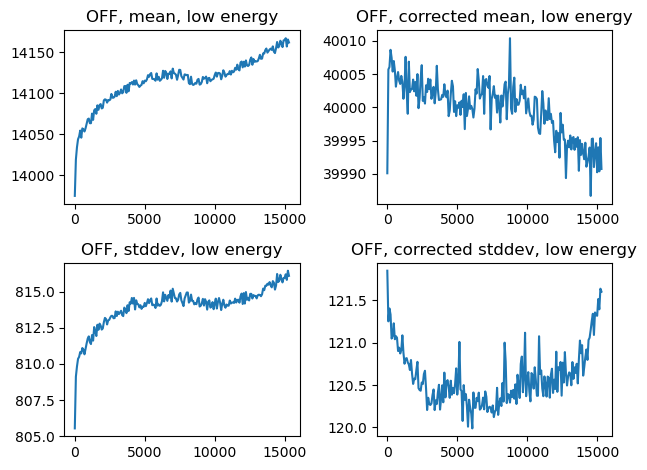

In [46]:
for sequence in dic_off_low.keys():
    array_correction = get_correction_matrix(dic_off_low[sequence]["array"])
    dic_off_low[sequence]["array_correction"] = copy.deepcopy(array_correction)

array_correction_sum = np.zeros((dic_off_low[1]["array_correction"].shape), dtype=np.float64)
for sequence in dic_off_low.keys():
    array_correction_sum += dic_off_low[sequence]["array_correction"]

array_correction_mean = array_correction_sum / len(dic_off_low)
np.savetxt(pathlib.Path("data/250605_off/correction_mean.csv").resolve(), array_correction_mean, fmt="%.3f", delimiter=",")

dic_off_low_corrected = copy.deepcopy(dic_off_low)
for key in dic_off_low:
    dic_off_low_corrected[key]["array"] = get_corrected_matrix(dic_off_low[key]["array"], array_correction_mean)
fig, axs = plt.subplots(2, 2)
plot_mean(dic_off_low, ax=axs[0, 0])
plot_std(dic_off_low, ax=axs[1, 0])
plot_mean(dic_off_low_corrected, ax=axs[0, 1])
plot_std(dic_off_low_corrected, ax=axs[1, 1])
axs[0, 0].set_title("OFF, mean, low energy")
axs[1, 0].set_title("OFF, stddev, low energy")
axs[0, 1].set_title("OFF, corrected mean, low energy")
axs[1, 1].set_title("OFF, corrected stddev, low energy")
plt.tight_layout()
plt.show()



## Distortion measurement

In [47]:
list_mean = []
list_std = []
for sequence in dic_off_low_corrected.keys():
	mean = dic_off_low_corrected[sequence]["array"].mean()
	std = dic_off_low_corrected[sequence]["array"].std()
	list_mean.append(mean)
	list_std.append(std)

std_of_mean = np.std(list_mean)
mean_of_std = np.mean(list_std)

print("Standard deviation of means:", std_of_mean)
print("Mean of standard deviations:", mean_of_std)



Standard deviation of means: 4.198040540263572
Mean of standard deviations: 120.597117282694


## Correction example, 100th image

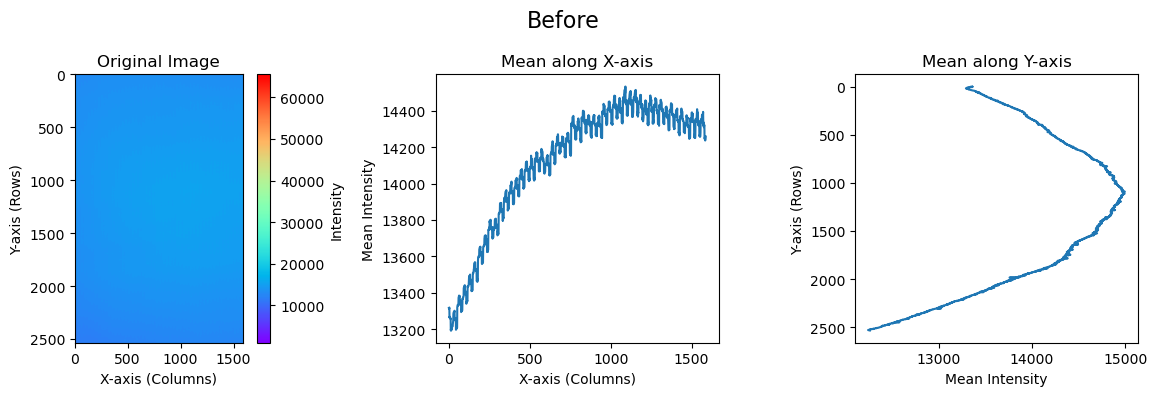

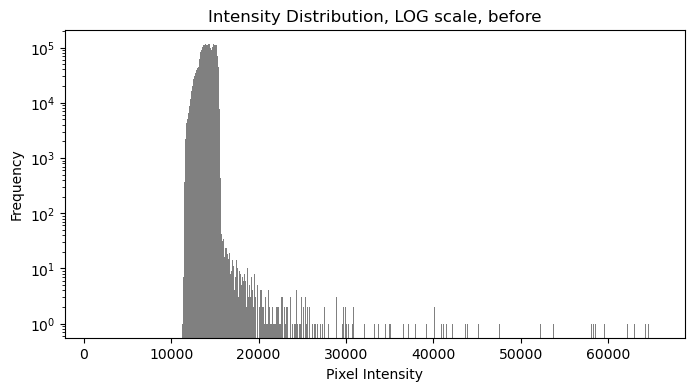

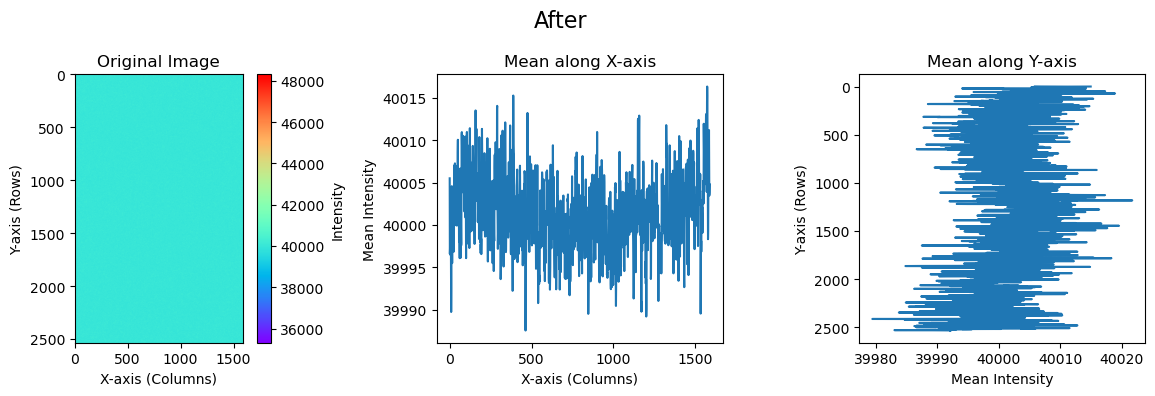

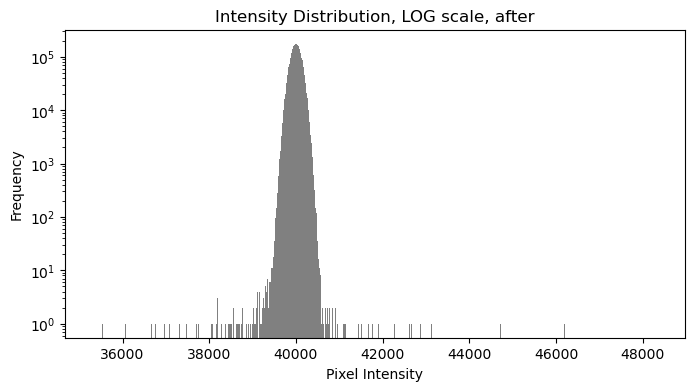

In [ ]:
index_sample = 100
key_sample = list(dic_off_low.keys())[index_sample]
array_before = dic_off_low[key_sample]["array"]
array_after = dic_off_low_corrected[key_sample]["array"]
img_show(array_before, "Before")
show_distribution_log_scale(array_before, "Intensity Distribution, LOG scale, before")
img_show(array_after, "After")
show_distribution_log_scale(array_after, "Intensity Distribution, LOG scale, after")

cv_before = array_before.std() / array_before.cv.mean()
cv_after = array_after.std() / array_after.cv.mean()
cv_on = dic_on_low[key_sample]["array"].std() / dic_on_low[key_sample]["array"].cv.mean()
print(f"coefficient of variation: before:{cv_before}, after:{cv_after}, on:{cv_on}")

print(f"Sample {key_sample} - Before mean: {array_before.mean()}, std: {array_before.std()}")
print(f"Sample {key_sample} - After mean: {array_after.mean()}, std: {array_after.std()}")